In [ ]:
import numpy as np
import pandas as pd

print(np.__version__)
print(pd.__version__)





2.4.1
2.3.3


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
days = 180
dates = pd.date_range(start="2025-08-01", periods=days, freq="D")

trend = np.linspace(50, 80, days)
weekly_season = 10 * np.sin(2 * np.pi * np.arange(days) / 7)
noise = np.random.normal(0, 5, days)

sales = np.maximum(0, trend + weekly_season + noise).round(0)

df = pd.DataFrame({"date": dates, "sales": sales})
df.head()


,date,sales
0,2025-08-01,52.0
1,2025-08-02,57.0
2,2025-08-03,63.0
3,2025-08-04,62.0
4,2025-08-05,45.0


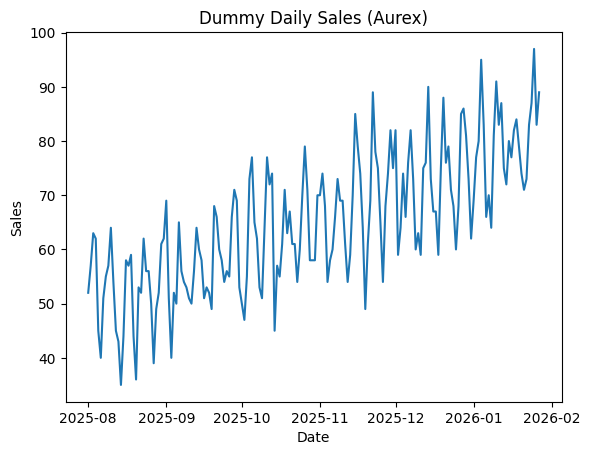

In [3]:
plt.figure()
plt.plot(df["date"], df["sales"])
plt.title("Dummy Daily Sales (Aurex)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [4]:
from sklearn.preprocessing import MinMaxScaler

values = df["sales"].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

def create_windows(series, lookback=14):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

lookback = 14
X, y = create_windows(scaled, lookback=lookback)
X.shape, y.shape



((166, 14, 1), (166, 1))

In [5]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# X: (samples, 14, 1)   y: (samples, 1)
X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32)

split = int(len(X_t) * 0.8)
X_train, X_test = X_t[:split], X_t[split:]
y_train, y_test = y_t[:split], y_t[split:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=16, shuffle=False)



In [8]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, features)
        out, _ = self.lstm(x)
        last = out[:, -1, :]          # last time step
        return self.fc(last)

model = LSTMForecast(input_size=1, hidden_size=50)
model


LSTMForecast(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch():
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(train_loader.dataset)

for epoch in range(1, 21):
    loss = train_one_epoch()
    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | train MSE: {loss:.6f}")


Epoch 05 | train MSE: 0.029704
Epoch 10 | train MSE: 0.026290
Epoch 15 | train MSE: 0.025428
Epoch 20 | train MSE: 0.023621


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

model.eval()
preds = []
trues = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        pred = model(xb).cpu().numpy()
        preds.append(pred)
        trues.append(yb.numpy())

y_pred = np.vstack(preds)
y_true = np.vstack(trues)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae, rmse


(0.14188213646411896, np.float64(0.17442064347618785))